## Знакомство с данными

Нужно проанализировать поведение клиентов и сделать выбор, какой из двух тарифов лучше. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

__Тариф «Смарт»__
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей
    
__Тариф «Ультра»__
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей
    
__Примечание__
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

### Описание данных

Таблица __users__ (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица **calls** (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица **messages** (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица **internet** (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица **tariffs** (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Знакомство с данными

Для начала импортируем все необходимые библиотеки.

In [2]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Приступим к изучению данных файлов

In [3]:
try: 
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')
except: 
    calls = pd.read_csv('calls.csv')
    internet = pd.read_csv('internet.csv')
    messages = pd.read_csv('messages.csv')
    tariffs = pd.read_csv('tariffs.csv')
    users = pd.read_csv('users.csv')

Напишем функцию, которая обработает каждый датасет и выведет по нему информацию.

In [4]:
def information(data):
    display(data.info())
    display(data.head(15))
    print('Выявлено дубликатов:', data.duplicated().sum())

In [5]:
information(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Выявлено дубликатов: 0


В колонке churn_date всего 38 значений, но это значит лишь, что абоненты не меняли свой тариф за время наблюдения.

In [6]:
users['city'].value_counts()

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Нижневартовск       1
Иваново             1
Химки               1
Подольск            1
Архангельск         1
Name: city, Length: 76, dtype: int64

Не заполненных значений в городах нет, мы знаем, где живут наши клиенты.

In [7]:
information(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Выявлено дубликатов: 0


In [8]:
information(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Выявлено дубликатов: 0


In [9]:
information(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


Выявлено дубликатов: 0


Понятно, для каждого пользователя дана детализация его действий. 

In [10]:
information(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Выявлено дубликатов: 0


Посмотрим наглядное распределение пользователей по тарифам.

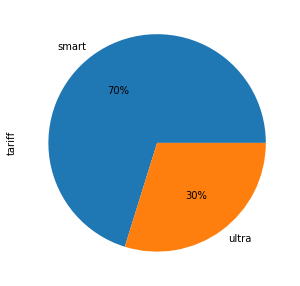

In [11]:
users['tariff'].value_counts().plot(kind='pie', autopct='%1.f%%', figsize=(7,5))

### Вывод

На первый взгляд информация в датасетах кажется хорошей, полной.

В датасете с интернетом лишняя колонка с индексами. Надо будет убрать. Во всех таблицах поменять формат столбца даты на DateTime.

Явных дубликатов в таблицах не обнаружено.

## Предобработка данных

### Замена типов данных

Начнём с замены типов данных в колонках с датами на формат DateTime.

In [12]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y.%m.%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


In [13]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y.%m.%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [14]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y.%m.%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [15]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y.%m.%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


Теперь всё в порядке.

### Поиск ошибок

Поищем нулевые значения в звонках и интернетах.

In [16]:
calls[calls['duration'] == 0.00]['duration'].count()

39613

In [17]:
calls[calls['duration'] == 0.00]['duration'].count() / len(calls['duration']) * 100

19.551644316336553

В наших наблюдениях 20% нулевых звонков.

In [18]:
internet[internet['mb_used'] == 0.00]['mb_used'].count()

19598

In [19]:
internet[internet['mb_used'] == 0.00]['mb_used'].count() / len(internet['mb_used']) * 100

13.118155773916303

И 13% нулевых интернетов. Сильно пугаться не будем, примем нулевые звонки - пропущенными, а нулевые интернеты - ошибочными сессиями. Двигаемся дальше.

Удалим лишний столбец в таблице интернет.

In [20]:
internet = internet.drop(['Unnamed: 0'], axis = 1)
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Не будем удалять нулевые значения, пусть остаются.

### Подготовка таблиц

Для начала надо округлить все минуты и мегабайты вверх, как это делается по правилам компании.

In [21]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls['duration'] = np.ceil(calls['duration'])
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


In [22]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet['mb_used'] = np.ceil(internet['mb_used'])
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,113.0,2018-11-25,1000,11
1,1000_1,1053.0,2018-09-07,1000,9
2,1000_2,1198.0,2018-06-25,1000,6
3,1000_3,551.0,2018-08-22,1000,8
4,1000_4,303.0,2018-09-24,1000,9


In [23]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


Теперь можно точно сказать, за сколько минут и мегабайтов пользователям начислили оплату.

### Подсчет данных для каждого пользователя


С помощью метода pivot_table создадим сводные таблицы, в которых сгруппируем пользователей по месяцам и количеству израсходованных элементов.

In [24]:
calls = calls.groupby(['user_id', 'month']).agg({'duration': 'sum'}).reset_index()
calls.head()

,user_id,month,duration
0,1000,5,159.0
1,1000,6,172.0
2,1000,7,340.0
3,1000,8,408.0
4,1000,9,466.0


In [25]:
internet = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()
internet.head()

,user_id,month,mb_used
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0


In [26]:
messages = messages.groupby(['user_id', 'month']).agg({'id': 'count'}).rename(columns = {'id': 'messages'}).reset_index()
messages.head()

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


У нас получилось разное количество строк в таблицах. Думаю, это связано с тем, что в некоторые месяцы пользователи не пользовались смсками, минутами и мегабайтами. Вот и получился ноль, который не посчитался.

По результатам сводных таблиц составим одну большую таблицу, в которую соберём все маленькие. И заполним пропуски нулями.

In [27]:
report = calls.merge(internet, on = ['user_id', 'month'], how = 'outer')\
              .merge(messages, on = ['user_id', 'month'], how = 'outer').fillna(0)
report = report.merge(users, on = 'user_id', how = 'left').merge(tariffs, left_on = 'tariff', 
                                                                 right_on = 'tariff_name', how = 'left')
report

,user_id,month,duration,mb_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5,159.0,2256.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1000,6,172.0,23257.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1000,7,340.0,14016.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
3,1000,8,408.0,14070.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1000,9,466.0,14581.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,11066.0,17.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3210,1489,9,0.0,17232.0,32.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3211,1489,10,0.0,19588.0,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3212,1489,11,0.0,17516.0,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart


Напишем функцию, которая посчитает перерасход по ежемесячной оплате для каждого пользователя.

In [53]:
def get_revenue(row):
    
    # считаем овердрафты
    minutes_over = (row['duration'] - row['minutes_included']) *  row['rub_per_minute']
    messages_over = (row['messages'] - row['messages_included']) * row['rub_per_message']
    internet_over = (row['mb_used'] - row['mb_per_month_included']) * row['rub_per_gb'] / 1024
    #делим на 1024, т.к. цена указана за гигабайт = 1024 мегабайт, а считаем мегабайты
    
    # убираем отрицательные овердрафты
    if minutes_over < 0: 
        minutes_over = 0
    if messages_over < 0:
        messages_over = 0
    if internet_over < 0:
        internet_over = 0
        
    if row['tariff'] == 'ultra':
        income = 1950
    if row['tariff'] == 'smart':
        income = 550
    
    # считаем выручку
    return round(minutes_over + messages_over + internet_over + income, 1)


report['revenue'] = report.apply(get_revenue, axis = 1)

In [54]:
report

,user_id,month,duration,mb_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
0,1000,5,159.0,2256.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
1,1000,6,172.0,23257.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
2,1000,7,340.0,14016.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
3,1000,8,408.0,14070.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
4,1000,9,466.0,14581.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,11066.0,17.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,550.0
3210,1489,9,0.0,17232.0,32.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,915.6
3211,1489,10,0.0,19588.0,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,1375.8
3212,1489,11,0.0,17516.0,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,971.1


### Вывод

Мы собрали все данные в одну таблицу, по которой теперь можно проводить анализ.

## Анализ данных

### Подсчет дисперсии, среднего и стандартного отклонения

Подсчитаем медиаонное значение, среднее, дисперсию и стандартное отклонение для обоих тарифов.

In [60]:
report.groupby('tariff').agg({'duration':['median','mean','var','std']})

duration                                       
         median        mean            var         std
tariff                                                
smart     422.0  417.934948   36219.315784  190.313730
ultra     518.0  526.623350  100873.633397  317.606098

Сделаем то же самое для интернета. 

In [61]:
report.groupby('tariff').agg({'mb_used':['median','mean','var','std']})

mb_used                                          
         median          mean           var           std
tariff                                                   
smart   16531.0  16229.188425  3.454591e+07   5877.576978
ultra   19324.0  19486.901523  1.019356e+08  10096.317202

И для смс

In [62]:
report.groupby('tariff').agg({'messages':['median','mean','var','std']})

messages                                   
         median       mean          var        std
tariff                                            
smart      28.0  33.384029   796.812958  28.227876
ultra      38.0  49.363452  2285.266143  47.804457

Посмотрим на значения по переплатам

In [63]:
report.groupby('tariff').agg({'messages':['median','mean','var','std']})

messages                                   
         median       mean          var        std
tariff                                            
smart      28.0  33.384029   796.812958  28.227876
ultra      38.0  49.363452  2285.266143  47.804457

### Вывод

Пользователи тарифа смарт в среднем расходуют 400 минут, 16000 мб и 30 смс. Пользователи тарифа ультра в среднем расходуют 500 минут, 20000 мб и 50 смс. Получается, пользователи тарифа ультра реже переплачивают за услуги, но их тариф и дороже.

## Проверка гипотез

### Первая гипотеза

Первая гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Примем гипотезу H0: "средняя выручка по тарифу Ультра равна средней выручке по тарифу Смарт". Тогда альтернативная гипотеза H1: "средняя выручка по тарифу Ультра НЕ равна средней выручке по тарифу Смарт"

Примем альфа = 0.01 и воспользуемся методом scipy.stats.ttest_ind() для проверки гипотезы, равны ли средние двух совокупностей.

In [47]:
results = st.stats.ttest_ind(users_smart['revenue'], users_ultra['revenue'], equal_var=True)
alpha = 0.01
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.172655564462924e-190
Отвергаем нулевую гипотезу


p-value получилось очень маленьким, значит, средние нулевая гипотеза будет верна с очень низкой вероятностью, отвергнем её.

### Вторая гипотеза

Вторая гипотеза - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Примем гипотезу H0: "средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов". Тогда альтернативная гипотеза H1: "средняя выручка пользователей из Москвы НЕ равна средней выручке пользователей из других регионов"

Для начала составим два датафрейма. В одном будут жители Москвы, в другом - жители остальных городов.

In [48]:
moscow_users = report.query('city == "Москва"')
moscow_users

,user_id,month,duration,mb_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
8,1001,11,430.0,18452.0,0.0,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3,smart,1153.906250
9,1001,12,414.0,14053.0,0.0,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3,smart,550.000000
17,1003,8,380.0,8571.0,37.0,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.000000
18,1003,9,961.0,12479.0,91.0,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.000000
19,1003,10,855.0,14779.0,83.0,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119,1490,9,322.0,14838.0,48.0,30,NaN,Москва,Радомир,Алесин,2018-04-03,smart,50,15360,500,550,200,3,3,smart,550.000000
3120,1490,10,312.0,20690.0,45.0,30,NaN,Москва,Радомир,Алесин,2018-04-03,smart,50,15360,500,550,200,3,3,smart,1591.015625
3121,1490,11,282.0,18733.0,47.0,30,NaN,Москва,Радомир,Алесин,2018-04-03,smart,50,15360,500,550,200,3,3,smart,1208.789062
3122,1490,12,290.0,15806.0,46.0,30,NaN,Москва,Радомир,Алесин,2018-04-03,smart,50,15360,500,550,200,3,3,smart,637.109375


In [49]:
other_users = report.query('city != "Москва"')
other_users

,user_id,month,duration,mb_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
0,1000,5,159.0,2256.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.000000
1,1000,6,172.0,23257.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.000000
2,1000,7,340.0,14016.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.000000
3,1000,8,408.0,14070.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.000000
4,1000,9,466.0,14581.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,11066.0,17.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,550.000000
3210,1489,9,0.0,17232.0,32.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,915.625000
3211,1489,10,0.0,19588.0,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,1375.781250
3212,1489,11,0.0,17516.0,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,971.093750


Возьмём альфа = 0.01

In [50]:
results = st.stats.ttest_ind(moscow_users['revenue'], other_users['revenue'], equal_var=True)
alpha = 0.01
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.47443187631524797
Не получилось отвергнуть нулевую гипотезу


Хоть p-value оказалось маленьким, оно всё-таки недостаточно мало, чтобы отвергнуть вторую гипотезу.

## Общий вывод

Выручка по тарифам различается, средние двух совокупностей не равны. Маркетинговому отделу нужно подумать, как распределить бюджеты, потому что один тариф для компании полусается выгоднее другого. По нашим данным могу предположить, что тариф ультра для компании выгоднее, т.к. его абонентская плата дороже. По доходности она не перекрывается даже переплатой пользователей тарифа смарт за дополнительные услуги.

Вторую гипотезу принимаем неверной и считаем, что маркетинговые кампании для разных городов России и для Москвы могут быть одинаковыми, т.к. их средние выручки примерно равны.